In [1]:
import numpy as np
import time 
from matplotlib import pyplot as plt
import gpflow
import pandas as pd
from gpflow.ci_utils import ci_niter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from TensorNetworkKernels import KernelWithTensorNetwork, KernelSpaceInducingPoints
from sklearn.cluster import KMeans

In [2]:
X_full, Y_full = np.load('./data/skillcraft/X.npy'), np.load('./data/skillcraft/y.npy')
x_train, x_test, y_train, y_test = train_test_split(X_full, Y_full, test_size = 0.1, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 1)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()

x_train, x_val, x_test= scaler_X.fit_transform(x_train), scaler_X.transform(x_val), scaler_X.transform(x_test)
y_train, y_val, y_test = scaler_Y.fit_transform(y_train.reshape(-1,1)), scaler_Y.transform(y_val.reshape(-1,1)), scaler_Y.transform(y_test.reshape(-1,1))

# CPD Kernel

In [3]:
cp_rank=2
local_dim=10
batch_size=256

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(x_train.shape[0]).batch(batch_size,
                                                                                            drop_remainder=True).repeat()

kernel = KernelWithTensorNetwork(gpflow.kernels.SquaredExponential(), batch_size=batch_size,
                                 cp_rank=cp_rank,local_dim=local_dim)

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_                           
inducing_variable_CP = kernel.CP(Z)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)

model= gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable , num_data=x_train.shape[0])    
gpflow.set_trainable(model.inducing_variable, True)
model.kernel.CP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cp__based (CP_Based)         (50, 1)                   360       
Total params: 360
Trainable params: 360
Non-trainable params: 0
_________________________________________________________________


Epoch:0, ELBO:-5161.38606279243
Epoch:1000, ELBO:-3530.1236438118913
Epoch:2000, ELBO:-2889.3642753833246
Epoch:3000, ELBO:-2704.4929977336365
Epoch:4000, ELBO:-2649.968103171221
Training Time :20.904348850250244
Train MSE:0.40093342989626, Train ELBO:-2614.2272807240943
Validation MSE:0.5687271522585026, Validation ELBO:-3176.3605152792434
Test MSE:0.474178422037965, Validation ELBO:-2861.2438723092564


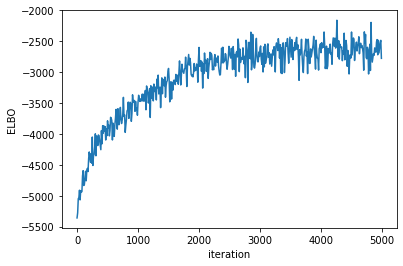

In [16]:
# Training

iterations = ci_niter(5000)

logf = []

train_iter=iter(train_dataset)
training_loss = model.training_loss_closure(train_iter,compile=True)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
start=time.time()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
    
for step in range(iterations):
    optimization_step()    
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        logf.append(elbo)
    if step % 1000==0:
        print("Epoch:{}, ELBO:{}".format(step,model.elbo(data=(x_train,y_train)))) 

end=time.time()
print("Training Time :{}".format(end-start))

plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))

# Tensor Network 

In [17]:
def local_feature_mapping(x_train,x_val,x_test,local_dim=2,unit_norm=False):
    
    n_train_samples = x_train.shape[0]
    n_val_samples = x_val.shape[0]
    n_test_samples = x_test.shape[0]
    n_features = x_train.shape[1]

    X_transformed_train_list = []
    X_transformed_val_list = []
    X_transformed_test_list = []
    
    for d in range(local_dim-1):
        X_transformed_train_list.append(x_train**(d+1))
        X_transformed_val_list.append(x_val**(d+1))
        X_transformed_test_list.append(x_test**(d+1))
         
    X_stand_train_list = [np.ones((n_train_samples,n_features))]
    X_stand_val_list = [np.ones((n_val_samples,n_features))]
    X_stand_test_list = [np.ones((n_test_samples,n_features))]
    
    for X_trans_train,X_trans_val,X_trans_test in zip(X_transformed_train_list,X_transformed_val_list,X_transformed_test_list):
         
      X_stand_train_list.append(X_trans_train)
      X_stand_val_list.append(X_trans_val) 
      X_stand_test_list.append(X_trans_test)
        
    x_train_processed= np.transpose(X_stand_train_list,(1, 2, 0))
    x_val_processed= np.transpose(X_stand_val_list,(1, 2, 0))
    x_test_processed = np.transpose(X_stand_test_list,(1, 2, 0))

    if(unit_norm==True):
      norms_train = np.sqrt(np.sum(x_train_processed**2,axis=-1,keepdims=True))
      x_train_processed = np.divide(x_train_processed,norms_train)

      norms_val = np.sqrt(np.sum(x_val_processed**2,axis=-1,keepdims=True))
      x_val_processed = np.divide(x_val_processed,norms_val)
    
      norms_test = np.sqrt(np.sum(x_test_processed**2,axis=-1,keepdims=True))
      x_test_processed = np.divide(x_test_processed,norms_test)

    return x_train_processed, x_val_processed, x_test_processed      


Epoch 1/500
11/11 [==============================] - 0s 13ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 2/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 3/500
11/11 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 4/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 5/500
11/11 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 6/500
11/11 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 7/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 8/500
11/11 [==============================] - 0s 3ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 9/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 10/500
11/11 [==============================] - 0s 4ms/step - loss: 1.0000 - val_loss: 0.9100
Epoch 11

11/11 [==============================] - 0s 3ms/step - loss: 0.9668 - val_loss: 0.8872
Epoch 84/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9662 - val_loss: 0.8895
Epoch 85/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9655 - val_loss: 0.8908
Epoch 86/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9649 - val_loss: 0.8928
Epoch 87/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9642 - val_loss: 0.8955
Epoch 88/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9635 - val_loss: 0.8975
Epoch 89/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9627 - val_loss: 0.8997
Epoch 90/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9620 - val_loss: 0.9026
Epoch 91/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9614 - val_loss: 0.9047
Epoch 92/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9606 - val_loss: 0.9057
Epoch 93/500


11/11 [==============================] - 0s 4ms/step - loss: 0.9340 - val_loss: 0.9640
Epoch 165/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9338 - val_loss: 0.9613
Epoch 166/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9338 - val_loss: 0.9584
Epoch 167/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9337 - val_loss: 0.9601
Epoch 168/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9335 - val_loss: 0.9665
Epoch 169/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9330 - val_loss: 0.9644
Epoch 170/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9329 - val_loss: 0.9632
Epoch 171/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9326 - val_loss: 0.9670
Epoch 172/500
11/11 [==============================] - 0s 4ms/step - loss: 0.9324 - val_loss: 0.9657
Epoch 173/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9322 - val_loss: 0.9670
Epoc

11/11 [==============================] - 0s 4ms/step - loss: 0.9181 - val_loss: 0.9860
Epoch 246/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9180 - val_loss: 0.9868
Epoch 247/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9178 - val_loss: 0.9861
Epoch 248/500
11/11 [==============================] - 0s 4ms/step - loss: 0.9177 - val_loss: 0.9893
Epoch 249/500
11/11 [==============================] - 0s 4ms/step - loss: 0.9174 - val_loss: 0.9882
Epoch 250/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9177 - val_loss: 0.9815
Epoch 251/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9169 - val_loss: 0.9850
Epoch 252/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9166 - val_loss: 0.9884
Epoch 253/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9168 - val_loss: 0.9920
Epoch 254/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9163 - val_loss: 0.9909
Epoc

11/11 [==============================] - 0s 4ms/step - loss: 0.9003 - val_loss: 1.0209
Epoch 327/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9001 - val_loss: 1.0203
Epoch 328/500
11/11 [==============================] - 0s 3ms/step - loss: 0.9001 - val_loss: 1.0224
Epoch 329/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8997 - val_loss: 1.0167
Epoch 330/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8996 - val_loss: 1.0155
Epoch 331/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8992 - val_loss: 1.0215
Epoch 332/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8991 - val_loss: 1.0238
Epoch 333/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8991 - val_loss: 1.0259
Epoch 334/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8985 - val_loss: 1.0190
Epoch 335/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8987 - val_loss: 1.0162
Epoc

11/11 [==============================] - 0s 3ms/step - loss: 0.8873 - val_loss: 1.0610
Epoch 408/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8871 - val_loss: 1.0629
Epoch 409/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8870 - val_loss: 1.0658
Epoch 410/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8869 - val_loss: 1.0666
Epoch 411/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8867 - val_loss: 1.0624
Epoch 412/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8869 - val_loss: 1.0643
Epoch 413/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8866 - val_loss: 1.0607
Epoch 414/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8865 - val_loss: 1.0596
Epoch 415/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8862 - val_loss: 1.0701
Epoch 416/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8862 - val_loss: 1.0718
Epoc

11/11 [==============================] - 0s 3ms/step - loss: 0.8790 - val_loss: 1.0963
Epoch 489/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8789 - val_loss: 1.0894
Epoch 490/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8788 - val_loss: 1.0886
Epoch 491/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8785 - val_loss: 1.0938
Epoch 492/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8784 - val_loss: 1.0963
Epoch 493/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8787 - val_loss: 1.0971
Epoch 494/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8784 - val_loss: 1.0957
Epoch 495/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8781 - val_loss: 1.0933
Epoch 496/500
11/11 [==============================] - 0s 4ms/step - loss: 0.8781 - val_loss: 1.0970
Epoch 497/500
11/11 [==============================] - 0s 3ms/step - loss: 0.8778 - val_loss: 1.0982
Epoc

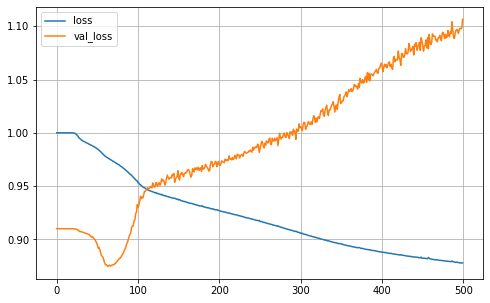

Training time:21.297810077667236
11/11 [==============================] - 0s 967us/step - loss: 1.3803
Test MSE:1.3802739381790161


In [21]:
from CP_Model import CP_Based
from tensorflow.keras.models import Sequential
from tensorflow import keras 

x_train_processed,x_val_processed,x_test_processed=local_feature_mapping(x_train,x_val,x_test,local_dim=local_dim,unit_norm=True)

model=Sequential()
model.add(CP_Based(units=1,activation=None,cp_rank=cp_rank,local_dim=local_dim,

                    initializer=keras.initializers.TruncatedNormal(mean=0, stddev=0.6)))

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

start = time.time()
history=model.fit(x_train_processed, y_train, epochs=500, batch_size=256,validation_data=(x_val_processed,y_val))
end = time.time()
model.summary()

train_loss=min(history.history['loss'])
val_loss=min(history.history['val_loss'])
print('train loss:{}'.format(train_loss))
print('validation loss:{}'.format(val_loss))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

print('Training time:{}'.format(end-start))
print('Test MSE:{}'.format(model.evaluate(x_test_processed,y_test)))



# Deep Kernel

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (50, 12)                  228       
_________________________________________________________________
dense_4 (Dense)              (50, 10)                  130       
_________________________________________________________________
dense_5 (Dense)              (50, 1)                   11        
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________
Epoch:0, ELBO:-5159.993824396843
Epoch:1000, ELBO:-2855.4362989828787
Epoch:2000, ELBO:-2539.551895371992
Epoch:3000, ELBO:-2451.3851681492442
Epoch:4000, ELBO:-2387.8616843374257
Training Time :12.77042818069458
Train MSE:0.33395308419677655, Train ELBO:-2374.739744991636
Validation MSE:0.5292880939242588, Validation ELBO:-3157.844678289345
Test MSE:0.44388653562030944, Validation E

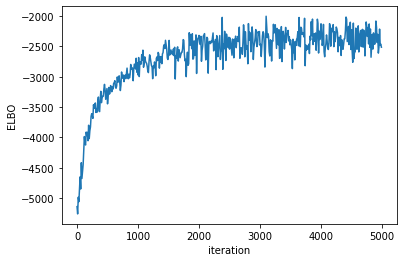

In [5]:
from DeepKernels import DeepKernel, KernelSpaceInducingPoints

batch_size=256
kernel = DeepKernel(gpflow.kernels.SquaredExponential(), batch_size=batch_size)

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_                           
inducing_variable_CP = kernel.CP(Z)
inducing_variable = KernelSpaceInducingPoints(inducing_variable_CP)

model= gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), inducing_variable , num_data=x_train.shape[0])    
gpflow.set_trainable(model.inducing_variable, True)
model.kernel.CP.summary()

# Training

iterations = ci_niter(5000)

logf = []

train_iter=iter(train_dataset)
training_loss = model.training_loss_closure(train_iter,compile=True)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)
start=time.time()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, model.trainable_variables)
    
for step in range(iterations):
    optimization_step()    
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        logf.append(elbo)
    if step % 1000==0:
        print("Epoch:{}, ELBO:{}".format(step,model.elbo(data=(x_train,y_train)))) 

end=time.time()
print("Training Time :{}".format(end-start))

plt.plot(np.arange(iterations)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))

print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))

# Gaussian Process with ARD RBF Kernel 

Train MSE:1.0000000000000004, Train ELBO:-3828.2942117436123
Validation MSE:1.1836220766721304, Validation ELBO:-4072.113601664745
Test MSE:0.9237879099574955, Validation ELBO:-3727.097309739525


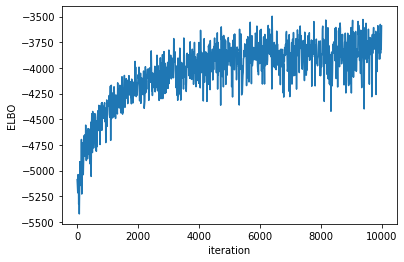

In [7]:
kernel= gpflow.kernels.SquaredExponential(lengthscales=[0.1]*x_train.shape[1]) #  ARD

M=50 # inducing points 

# Cluster Initialization of Inducing Points 
inducing_variable_kmeans = KMeans(n_clusters=M,random_state=0).fit(x_train)   
Z=inducing_variable_kmeans.cluster_centers_    

model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, num_data=x_train.shape[0])
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(x_train.shape[0])

minibatch_size = 256
gpflow.set_trainable(model.inducing_variable, True)


def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)
    optimizer = tf.optimizers.Adam(learning_rate=1e-3)

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

maxiter = ci_niter(10000)

logf = run_adam(model, maxiter)
plt.plot(np.arange(maxiter)[::10], logf)
plt.xlabel("iteration")
_ = plt.ylabel("ELBO")

train_mean, train_var = model.predict_f(x_train) 
train_elbo=model.elbo(data=(x_train,y_train))

train_mse=tf.reduce_mean(tf.losses.MSE(train_mean,y_train))

val_mean, val_var = model.predict_f(x_val)
val_elbo = model.elbo(data=(x_val,y_val))

val_mse=tf.reduce_mean(tf.losses.MSE(val_mean,y_val))

test_mean, val_var = model.predict_f(x_test)
test_elbo = model.elbo(data=(x_test,y_test))

test_mse=tf.reduce_mean(tf.losses.MSE(test_mean,y_test))


print("Train MSE:{}, Train ELBO:{}".format(train_mse,train_elbo))
print("Validation MSE:{}, Validation ELBO:{}".format(val_mse,val_elbo))
print("Test MSE:{}, Validation ELBO:{}".format(test_mse,test_elbo))